In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
from flowprintOptimal.sekigo.modeling.loggers import Logger
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch.nn.functional as F
from flowprintOptimal.sekigo.ood.GAN.datasets import SineWaveDataset,FreqWaveDataset
from flowprintOptimal.sekigo.modeling.neuralNetworks import TransformerGenerator,CNNNetwork,Predictor,CNNNetwork1D
from flowprintOptimal.sekigo.ood.GAN.trainers import GANTrainer
from flowprintOptimal.sekigo.modeling.neuralNetworks import LSTMNetwork
from flowprintOptimal.sekigo.ood.GAN.utils import BatchReplacer
from flowprintOptimal.sekigo.ood.GAN.trainers import OODTrainer
from flowprintOptimal.sekigo.flowUtils.flowDatasets import DDQNActivityDataset
from flowprintOptimal.sekigo.dataAnalysis.vNATDataFrameProcessor import VNATDataFrameProcessor
from flowprintOptimal.sekigo.flowUtils.commons import loadFlows, saveFlows
from flowprintOptimal.sekigo.flowUtils.sampler import FixedLengthSampler
import pandas as pd
from flowprintOptimal.sekigo.core.flowConfig import FlowConfig
from flowprintOptimal.sekigo.dataAnalysis.dataFrameProcessor import SoftwareUpdateDataProcessor,GamingDownloadDataFrameProcessor
from flowprintOptimal.sekigo.dataAnalysis.dataFrameExtractor import DataFrameExtractor
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from flowprintOptimal.sekigo.ood.GAN.trainers import GANTrainer
from flowprintOptimal.sekigo.utils.evaluations import evaluateModelOnDataSet
from flowprintOptimal.sekigo.utils.commons import augmentData
np.set_printoptions(precision=2)
from copy import deepcopy

In [2]:
flow_config = FlowConfig(grain= 1, band_thresholds= [1250])
processor1 = SoftwareUpdateDataProcessor(parquet_path= "data/software-update-1w.parquet")
processor2 = GamingDownloadDataFrameProcessor(parquet_path= "data/2023-12-01--2023-12-31--flowprint.parquet")
flows = DataFrameExtractor.getData(data_frame_processors= [processor2,processor1],needed_flow_config= flow_config)

initial software update length = 72826
final software update length = 36790
after adding uploads size = 73580


In [3]:
#flows = loadFlows(path= "/Users/rushi/Desktop/UNSW/data/VNAT/flowStore/vnatflows1second.json")
#class_type_filtered_flows = VNATDataFrameProcessor.convertLabelsToTopLevel(flows)

In [4]:
class_type_filtered_flows = flows
FT_filtered_flows = list(filter(lambda x : x.class_type != "Conferencing",class_type_filtered_flows))
FT_flows = list(filter(lambda x : x.class_type == "Conferencing",class_type_filtered_flows))
len(FT_filtered_flows) + len(FT_flows) == len(class_type_filtered_flows)

True

In [5]:
sampler = FixedLengthSampler(flow_config= FT_filtered_flows[0].flow_config,required_length_in_seconds = 30,ratio_of_median_to_sample= .01,min_activity_for_start_point= 25,sample_wise_train_ratio= .8, temporal_train_ratio= 1)
FT_filtered_split_flows = sampler.sampleAndCutToLength(data= FT_filtered_flows)
ft_sampler = FixedLengthSampler(flow_config= FT_filtered_flows[0].flow_config,required_length_in_seconds = 30,ratio_of_median_to_sample= .05,min_activity_for_start_point= 25,sample_wise_train_ratio= 1, temporal_train_ratio= 1)
FT_split_flows = ft_sampler.sampleAndCutToLength(data= FT_flows)
all_sampler = FixedLengthSampler(flow_config= class_type_filtered_flows[0].flow_config,required_length_in_seconds = 30,ratio_of_median_to_sample= .01,min_activity_for_start_point= 25,sample_wise_train_ratio= .8, temporal_train_ratio= 1)
all_flows = all_sampler.sampleAndCutToLength(data= class_type_filtered_flows)

{'Video': 0.008195859497708501, 'Download': 0.010022536113392067, 'Upload': 0.009999818986434214}
overlapping points = 0
{'Conferencing': 0.049998761662485805}
overlapping points = 0
{'Video': 0.009097623355554911, 'Conferencing': 0.02495073185747089, 'Download': 0.011125283279024218, 'Upload': 0.01110006666021314}
overlapping points = 0


In [6]:
print(pd.Series(map(lambda x : x.class_type,FT_filtered_split_flows["train_flows"])).value_counts())
print(pd.Series(map(lambda x : x.class_type,FT_filtered_split_flows["test_flows"])).value_counts())
print(pd.Series(map(lambda x : x.class_type,all_flows["train_flows"])).value_counts())
print(pd.Series(map(lambda x : x.class_type,all_flows["test_flows"])).value_counts())
print(pd.Series(map(lambda x : x.class_type,FT_split_flows["train_flows"])).value_counts())

Video       29336
Upload      28416
Download    28358
Name: count, dtype: int64
Video       7374
Download    7005
Upload      6947
Name: count, dtype: int64
Download        32384
Video           29374
Upload          28363
Conferencing    18650
Name: count, dtype: int64
Download        8110
Video           7336
Upload          7000
Conferencing    4648
Name: count, dtype: int64
Conferencing    38027
Name: count, dtype: int64


In [7]:
all_train_dataset = DDQNActivityDataset(flows= all_flows["train_flows"],label_to_index= None)
all_test_dataset = DDQNActivityDataset(flows = all_flows["test_flows"], label_to_index= all_train_dataset.label_to_index)
train_dataset = DDQNActivityDataset(flows= FT_filtered_split_flows["train_flows"],label_to_index= None)
test_dataset = DDQNActivityDataset(flows= FT_filtered_split_flows["test_flows"],label_to_index= train_dataset.label_to_index)
ood_dataset = DDQNActivityDataset(flows= FT_split_flows["train_flows"],label_to_index= None)

In [8]:
#train_dataset = FreqWaveDataset(num_timesteps= 25,dataset_length= 10000,ts_dim= 1)
#test_dataset = FreqWaveDataset(num_timesteps= 25,dataset_length= 100,ts_dim= 1)
logger = Logger(name= "GAN",verbose= True)
logger.default_step_size = 1000

In [9]:
generator = TransformerGenerator(output_dim = 4,random_dim= 1,embedding_dim= 64,num_heads= 4, num_layers= 5,device= device,seq_len= 30,is_img= False)
discriminator = CNNNetwork1D(ts_dim= 4,num_filters= 32, kernel_sizes= [5,9,13,19],output_dim= 1)
classifier = LSTMNetwork(lstm_hidden_size= 32,lstm_input_size= 4,output_dim = len(train_dataset.label_to_index) + 1)

In [10]:
trainer = OODTrainer(generator= generator,discriminator= discriminator,n=2,
                     classifier = classifier,logger= logger,device= device,classifier_only= False)

GAN ---- 1000 metric classifier_loss = 1.6352856279611587
GAN ---- 1000 metric classifier_aug_loss = 0.4268600522428751
GAN ---- 1000 metric 0_discriminator_loss = -1.4375516298040747
GAN ---- 1000 metric 0_cost_wd = -1.9459535917937756
GAN ---- 1000 metric 0_gp_loss = 0.5084019615836441
GAN ---- 1000 metric 1_discriminator_loss = -1.9032259443104267
GAN ---- 1000 metric 1_cost_wd = -2.6533232634812594
GAN ---- 1000 metric 1_gp_loss = 0.7500973180774599
GAN ---- 1 metric train_f1 = 0.8439056425336613
GAN ---- 1 metric test_f1 = 0.8464924954413919
GAN ---- 1 metric ood_accuracy = 0.4928077418676204
tensor([[-1.1398]], device='cuda:0')


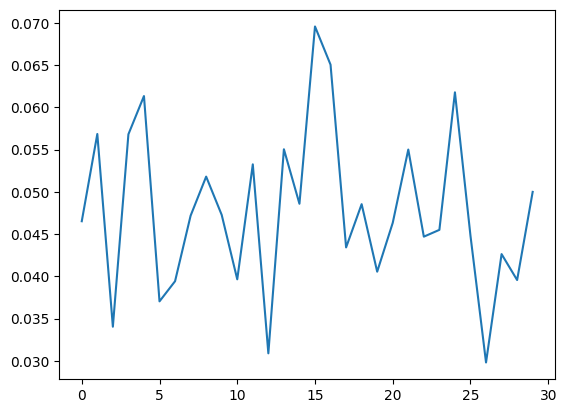

tensor([[0.4592]], device='cuda:0')


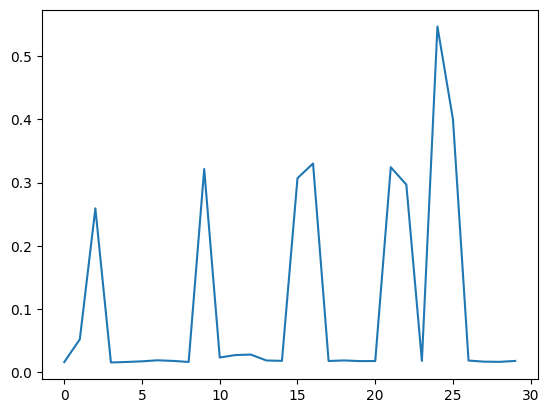

KeyboardInterrupt: 

In [11]:
trainer.train(train_dataset= train_dataset,test_dataset= test_dataset,epochs= 500,batch_size= 128,n_critic= 3,ood_dataset= ood_dataset,
              gp_weight=1, lr_classifier= 1e-4, lr_discriminator= 1e-4,lr_generator= 1e-4) 

In [46]:
trainer.generators[1].save(model_path= "models/generators/generator1.pt")

In [44]:
test_gen = TransformerGenerator(output_dim = 4,random_dim= 1,embedding_dim= 64,num_heads= 4, num_layers= 5,device= device,seq_len= 30,is_img= False)

In [47]:
test_gen.load("models/generators/generator1.pt")

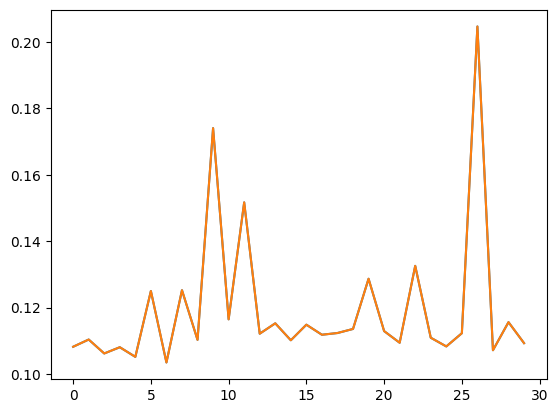

In [57]:
trainer.generators[1].to(device)
trainer.generators[1].eval()
test_gen.eval()
with torch.no_grad():
    Z = test_gen.generateRandomZ(batch_size= 1).to(device)
    a = test_gen(Z)
    b = trainer.generators[1](Z)

plt.plot(a[0,:,0].cpu())
plt.plot(b[0,:,0].cpu())

In [14]:
feature_extractor = LSTMNetwork(lstm_hidden_size= 64,lstm_input_size=4,output_dim = 32)
classifier_ = Predictor(feature_dim=32,num_classes= len(train_dataset.label_to_index))
from flowprintOptimal.sekigo.modeling.trainers import NNClassificationTrainer
classification_trainer = NNClassificationTrainer(feature_extractor= feature_extractor,classifier= classifier_,device= device,logger= Logger(name= "classification"))
classification_trainer.train(train_dataset= train_dataset,test_dataset= test_dataset,epochs= 10,batch_size= 64,lr= .0001)


classification ---- 1 metric test_f1 = 0.16528201850931382
classification ---- 1 metric train_f1 = 0.16504845899522824
classification ---- 10 metric train_loss = 1.0966433882713318
classification ---- 20 metric train_loss = 1.093203055858612
classification ---- 30 metric train_loss = 1.092376458644867
classification ---- 40 metric train_loss = 1.087407147884369
classification ---- 50 metric train_loss = 1.0909533739089965
classification ---- 60 metric train_loss = 1.0783987641334534
classification ---- 70 metric train_loss = 1.077331817150116
classification ---- 80 metric train_loss = 1.0735108852386475
classification ---- 90 metric train_loss = 1.0696343660354615
classification ---- 100 metric train_loss = 1.0565672993659974
classification ---- 110 metric train_loss = 1.0472667574882508
classification ---- 120 metric train_loss = 1.0427277445793153
classification ---- 130 metric train_loss = 1.0296971082687378
classification ---- 140 metric train_loss = 1.0134859204292297
classificati

In [15]:
real_features = []
labels = []
loader = DataLoader(train_dataset,batch_size=64)

feature_extractor.eval()
with torch.no_grad():
    for batch in loader:
        batch_out = feature_extractor(batch["data"].float().to(device)).cpu().numpy().tolist()
        batch_labels = batch["label"].numpy().tolist()
        labels.extend(batch_labels)
        real_features.extend(batch_out)

real_features = np.array(real_features)
labels = np.array(labels)

ood_features = []
ood_preds = []
loader = DataLoader(ood_dataset,batch_size=64)
with torch.no_grad():
    for batch in loader:
        batch_out = feature_extractor(batch["data"].float().to(device)).cpu().numpy().tolist()
        ood_features.extend(batch_out)


        # use the trainer's classifier here
        batch_out = torch.argmax(trainer.classifier(batch["data"].float().to(device)),dim= -1).cpu().numpy().tolist()
        ood_preds.extend(batch_out)
        
        
ood_features = np.array(ood_features)

In [19]:
ood_preds = np.array(ood_preds)

(ood_preds == 3).sum()/ood_preds.shape[0]

0.9588187340573803

In [21]:
fake_features = []
for index in range(trainer.n):
    
    with torch.no_grad():
        trainer.generators[index].eval().to(device)
        for _ in range(100):
            generator = trainer.generators[index]
            fake_data = generator(generator.generateRandomZ(batch_size= 32).to(device))
            batch_out = feature_extractor(fake_data).cpu().numpy().tolist()
            fake_features.extend(batch_out)
fake_features = np.array(fake_features)

In [22]:
real_features = real_features[np.random.randint(low= 0,high= real_features.shape[1],size= 20000)]
#ood_features = ood_features[np.random.randint(low= 0,high= ood_features.shape[1],size= 20000)]

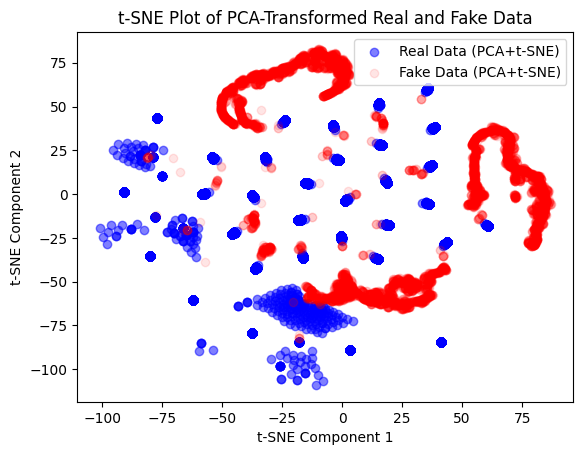

In [23]:
from sklearn.manifold import TSNE


# Fit t-SNE on PCA-transformed real data
tsne = TSNE(n_components=2, random_state=42)
all_data = np.array(real_features.tolist() + fake_features.tolist())
tsne_data = tsne.fit_transform(all_data)

tsne_real_data = tsne_data[:len(real_features)]
tsne_fake_data = tsne_data[len(real_features):]

# Plot t-SNE of PCA-transformed real and fake data
plt.scatter(tsne_real_data[:, 0], tsne_real_data[:, 1], label='Real Data (PCA+t-SNE)', c='blue', alpha=0.5)
plt.scatter(tsne_fake_data[:, 0], tsne_fake_data[:, 1], label='Fake Data (PCA+t-SNE)', c='red', alpha=0.1)

# Add labels and legend
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Plot of PCA-Transformed Real and Fake Data')
plt.legend()


In [ ]:
ood_dataset = FreqWaveDataset(ts_dim= 1,dataset_length= 1000,freq_ranges= [(1,.4)], num_timesteps= 25)

In [ ]:
def testOOD(classifier : LSTMNetwork,discriminator : CNNNetwork1D, ood_dataset : FreqWaveDataset):

    loader = DataLoader(ood_dataset,batch_size= 32)
    classifier = classifier.to(device).eval()
    discriminator = discriminator.to(device).eval()
    total_ood = 0
    count = 0
    dis_scores = []
    with torch.no_grad():
        for batch in loader:
            X = batch["data"].float().to(device)
            #X = torch.randn_like(X).to(device)
            preds = torch.argmax(classifier(X),dim= -1)
            ood = (preds == 2).sum()
            total_ood += ood

            scores = discriminator(X)
            dis_scores.extend(scores.cpu().numpy()[:,0].tolist())

            count += X.shape[0]
    print(total_ood/count)
    return np.array(dis_scores)


In [ ]:
scores = testOOD(classifier=classifier,discriminator= trainer.super_discriminator,ood_dataset= ood_dataset)

tensor(0.7231, device='cuda:0')


In [ ]:
# for 2 to 3
print()
print(pd.Series(scores).describe())


count    325.000000
mean      -2.748871
std        0.681535
min       -4.433862
25%       -3.247192
50%       -2.865038
75%       -2.233341
max       -1.142857
dtype: float64


(array([ 7.,  6., 35., 61., 61., 47., 35., 44., 21.,  8.]),
 array([-4.43, -4.1 , -3.78, -3.45, -3.12, -2.79, -2.46, -2.13, -1.8 ,
        -1.47, -1.14]),
 <BarContainer object of 10 artists>)

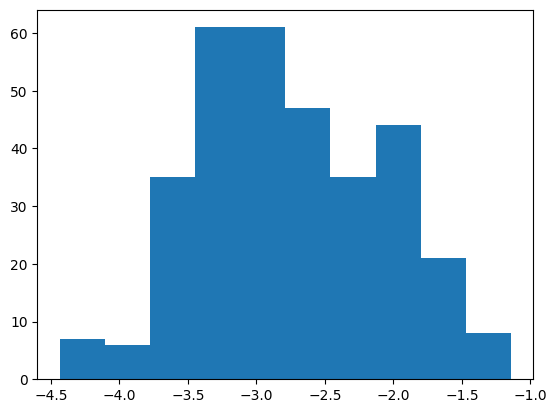

In [ ]:
plt.hist(scores)

In [ ]:
# train dataset .1735
# ood dataset .1851

In [ ]:
# batch replacement
# train_dataset .0757
# ood dataset .6308

In [ ]:
a = torch.tensor([10,11]).float()
print(F.softmax(a,dim= -1))
(-F.softmax(a,dim = -1)*F.log_softmax(a,dim= -1)).sum()

tensor([0.2689, 0.7311])


tensor(0.5822)

In [ ]:
loader = DataLoader(train_dataset,batch_size = 10)

In [ ]:
for i in loader:
    break

In [ ]:
discriminator(torch.randn(5,25,1).to(device))

tensor([[0.0272],
        [0.0333],
        [0.0429],
        [0.0414],
        [0.0500]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
discriminator(i["data"].float().to(device))

tensor([[ 0.0299],
        [ 0.0088],
        [ 0.0458],
        [ 0.0022],
        [ 0.0347],
        [ 0.0435],
        [-0.0004],
        [ 0.0039],
        [ 0.0207],
        [ 0.0280]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
torch.argmax(F.softmax(classifier(torch.rand_like(i["data"]).float().to(device)),dim= -1),dim= -1).cpu().detach().numpy()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [ ]:
torch.argmax(F.softmax(classifier(i["data"].float().to(device)),dim= -1),dim= -1)

tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')

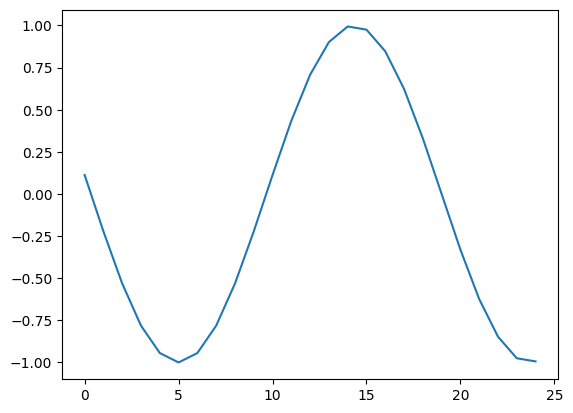

In [ ]:
plt.plot(train_dataset[np.random.randint(len(train_dataset))]["data"][:,0])

tensor([[-1.8254]], device='cuda:0')
tensor([[7.2340e-03, 2.6833e-04, 6.4070e-04, 9.9186e-01]], device='cuda:0')


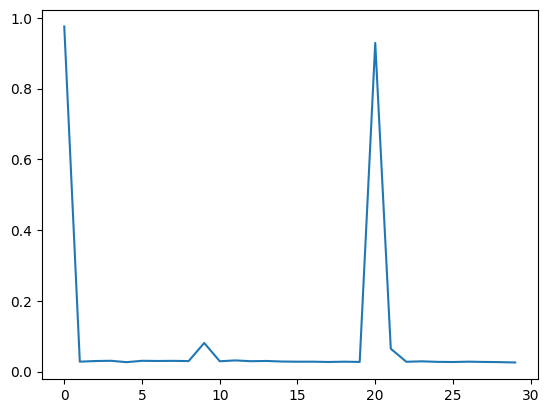

In [41]:
with torch.no_grad():
    generator = trainer.generators[-1]
    generator.eval()
    generated = generator.to(device)(generator.generateRandomZ(batch_size= 1).to(device))
    #generated = generator.to(device)(torch.tensor(np.random.normal(loc= 1,scale= 1,size= (1,25,16))).float().to(device))
    print(discriminator(generated))
    print(F.softmax(classifier(generated),dim= -1))
    generated = generated[0,:,1].cpu()
plt.plot(generated)

In [ ]:
print(generated)

tensor([0.0032, 0.0018, 0.0019, 0.0033, 0.0039, 0.0013, 0.0026, 0.0017, 0.0032,
        0.0031])


In [ ]:
freq_ranges = ((.1,.5),(1,1.4))
timestamps = np.arange(25)
sampled_freq, sampled_phase = .8,0
wave = np.sin(timestamps*sampled_freq + sampled_phase)

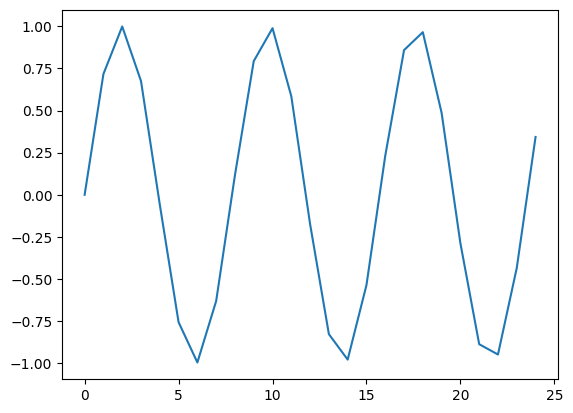

In [ ]:
plt.plot(wave)

In [ ]:
F.softmax(classifier(torch.tensor(wave).float().to(device).unsqueeze(0).unsqueeze(-1)),dim= -1)

tensor([[0.3845, 0.6155]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

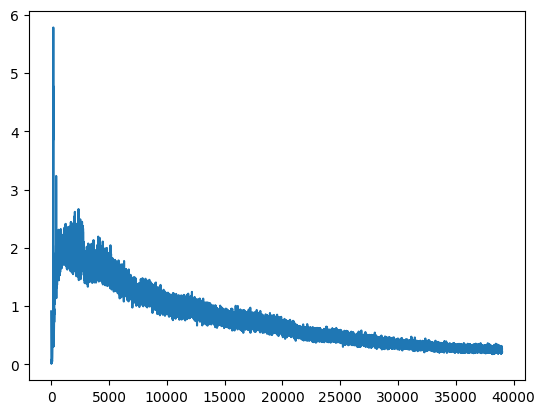

In [ ]:
plt.plot(logger.getMetric("gp_loss"))

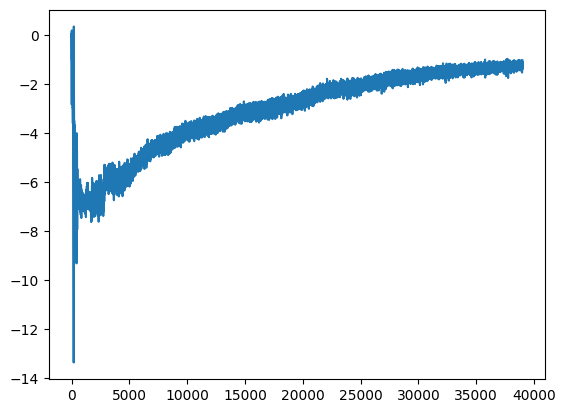

In [ ]:
plt.plot(logger.getMetric("cost_wd"))

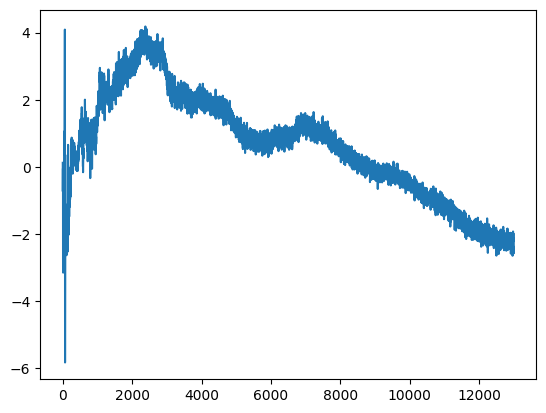

In [ ]:
plt.plot(logger.getMetric("generator_loss"))

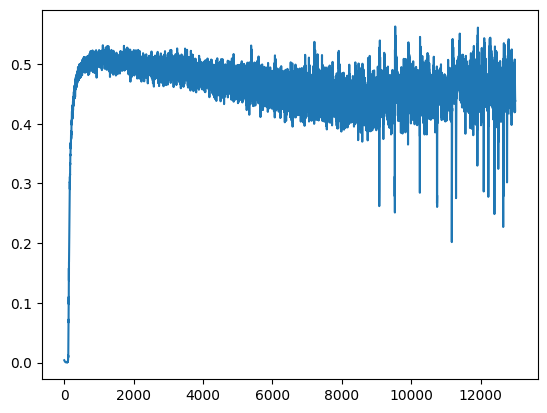

In [ ]:
plt.plot(logger.getMetric("generator kl loss"))

In [ ]:
predicted = []
labels = []
with torch.no_grad():
    for batch in DataLoader(train_dataset,batch_size= 32):
        X,y = batch["data"], batch["label"]
        y_pred = torch.argmax(classifier(X.to(device).float()),dim= -1).cpu().numpy().tolist()

        predicted.extend(y_pred)
        labels.extend(y.cpu().numpy().tolist())

        

In [ ]:
predicted = np.array(predicted)
labels = np.array(labels)

In [ ]:
(predicted == labels).sum()

5000